In [1]:
import os
from os.path import join
import numpy as np
import shutil
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from glob import glob
from scipy.spatial.transform import Rotation
from exr import read_exr

In [2]:
base_dir = '/bigpen/simulator_data/LEC_fast_result'

In [55]:
%matplotlib widget

old_poses = []
with open('/bigpen/simulator_data/LEC_fast_result/trajectory.txt', 'r') as f:
    for line in f:
        if line[0]=='#':
            continue
        parsed = line.split(' ')
        # print(parsed)
        old_poses.append([float(x) for x in parsed])
old_pose_arr = np.array(old_poses)
# old_pose_arr[:,1:4] -= old_pose_arr[0,1:4]
old_z_direction = Rotation.from_quat(old_pose_arr[:,4:]).as_matrix()
print(old_z_direction[10].T@old_z_direction[10])

skeletons = np.load("/playpen/skeleton-on-surface/figures/LEC_fast/skeletons.npy").astype(int)
step = 2
skeletons = skeletons[::step]
old_pose_arr = old_pose_arr[::step]
old_z_direction = old_z_direction[::step]

[[ 1.00000000e+00 -1.15154016e-17 -1.19735230e-16]
 [-1.15154016e-17  1.00000000e+00  1.00967540e-17]
 [-1.19735230e-16  1.00967540e-17  1.00000000e+00]]


In [102]:
# x is right, y is down in camera coords
cx = skeletons.shape[-1]//2
cy = skeletons.shape[-2]//2
fx = 144.2398/135*cx*2
fy = 144.2398/108*cy*2
camera_mat = np.array(
    [[fx, 0, cx],
     [0, fy, cy],
     [0, 0, 1]]
).astype(float)
inv_camera_mat = np.linalg.inv(camera_mat)

/tmp/ipykernel_1519788/1324546938.py:41: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



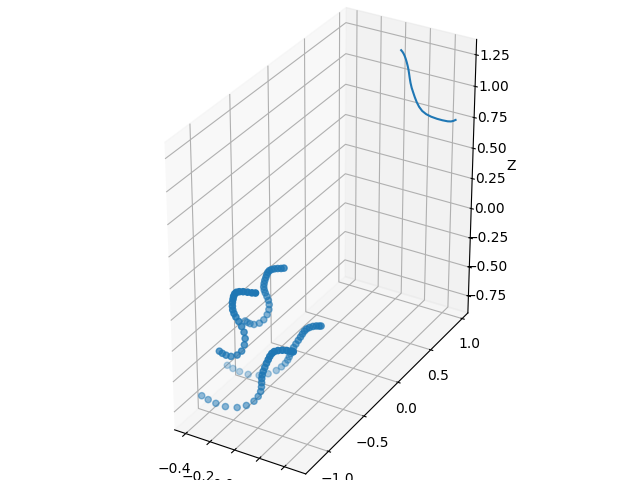

In [108]:
Rt = np.zeros((len(skeletons), 4, 4))
Rt[:,:3,:3] = old_z_direction
Rt[:,:3,3] = old_pose_arr[:,1:4]
Rt[:,3,3] = 1

points = []
rng = np.random.default_rng()
for i, sk in enumerate(skeletons):
    coords = np.vstack(np.where(sk>0))

    # Pick 25 points at random
    rng.shuffle(coords, axis=1)
    coords = coords[:,:25] if coords.shape[1]>=25 else coords
    coords = coords.astype(int)

    coords = np.array([[sk.shape[0]//4, sk.shape[0]//4, 3*sk.shape[0]//4, 3*sk.shape[0]//4],
                      [sk.shape[1]//4, 3*sk.shape[1]//4, sk.shape[1]//4, 3*sk.shape[1]//4]])
    # coords[1] = sk.shape[0] - coords[1]

    # Read in depths
    depths = read_exr(f"/bigpen/simulator_data/LEC_fast/LEC_depth{step*i+120:05}.exr")
    # zs = depths[coords[0], coords[1]]
    zs = np.ones_like(coords[1]).astype(float)

    # Transform coords to world coordinates
    # coords = np.vstack([coords, np.ones_like(zs)])
    # coords =  inv_camera_mat @ coords
    coords = coords.astype(float)
    coords -= np.array([[cx], [cy]])
    coords[0] *= 1/fx
    coords[1] *= 1/fy
    coords = coords*zs
    coords = np.vstack([coords, zs, np.ones_like(zs)])
    coords = np.linalg.inv(Rt[i]) @ coords
    points.append(coords)

points = np.hstack(points)
points = points[:3]

fig = plt.figure()
ax = Axes3D(fig)
ax.set_box_aspect([np.ptp(r) for r in np.hstack([points, old_pose_arr.T[1:4]])])
ax.set_xlabel('X')
ax.set_zlabel('Z')
colors = old_pose_arr[:,0]
ax.plot(*old_pose_arr.T[1:4])
# ax.scatter(*old_pose_arr.T[1:4], c=colors)
ax.scatter(*points)

# ax.quiver(*old_pose_arr.T[1:4], *(old_z_direction[:,:,2].T), color='orange', length=0.1)
# ax.quiver(*old_pose_arr.T[1:4], *(old_z_direction[:,:,1].T), color='red', length=0.03)
# ax.quiver(*old_pose_arr.T[1:4], *(old_z_direction[:,:,0].T), color='green', length=0.03)

In [45]:
import plotly.express as px
import pandas as pd

coords = ['t','x', 'y', 'z']
df = pd.DataFrame({coords[i]:old_pose_arr[:,i] for i in range(4)})
px.scatter_3d(df, x='x', y='y', z='z', color='t')